In [2]:
# Packages
using LaTeXStrings
using Plots
using Random

# File inclusions
include("../../supervised-learning/src/modules/ActFunctions.jl")
include("../../supervised-learning/src/modules/Brain.jl")
include("../../supervised-learning/src/modules/Tools.jl")

# Activation Functions
sig = Sigmoid();

# Plots defaults
default(show = true)


┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9]
└ @ Base loading.jl:1278
┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1278


# Autoencoder


In [3]:
mutable struct AutoEncoder
    brain::Brain
    l::Int64
    learn_input::Function
    reduce_dimensions::Function

    function AutoEncoder(m::Int64, l::Int64, ϕ::C1Function)
        this = new()
        this.l = l

        # MLP
        this.brain = Brain(m, m, [l], [ϕ, ϕ])

        # Learn the input
        this.learn_input = function learn_input(x; η=0.1, α=0.1, epocs=50)
            grads, avg_err = this.brain.learn_data(x, x, η=η, α=α, epocs=epocs)
            return grads, avg_err
        end

        # Get reduced dimension data
        this.reduce_dimensions = function reduce_dimensions(x)
            red_data = zeros(size(x, 1), l)
            weights = this.brain.ω[1]
            ϕ = this.brain.ϕ[1]

            # Get data
            for i in 1:size(x, 1)
                xᵣ = [x[i, :]; 1]
                red_data[i, :] = ϕ.eval.(weights' * xᵣ)
            end

            return red_data
        end

        return this
    end
end


## Data Codification


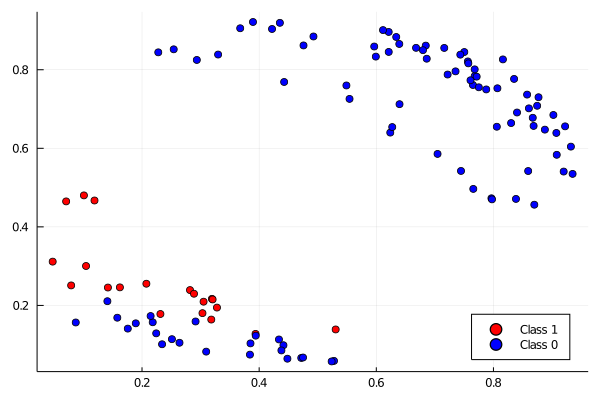

In [9]:
Random.seed!(1234)

# Data
datax, datay = create_data("../../supervised-learning/src/data/num-data.csv", sep = false)

# Codification
autoencoder = AutoEncoder(size(datax, 2), 2, sig)
grads, avg_err = autoencoder.learn_input(datax, η=0.9, α=0.3, epocs=200)
datax_red = autoencoder.reduce_dimensions(datax)

# Separation
datax_red_1 = datax_red[datay[:, 1] .== 1, :]
datax_red_0 = datax_red[datay[:, 1] .== 0, :]

# Plot reduced data
p = scatter(datax_red_1[:, 1], datax_red_1[:, 2], label="Class 1", color=:red)
scatter!(datax_red_0[:, 1], datax_red_0[:, 2], label="Class 0", color=:blue,
         legend=:bottomright)

save = false
if save
    savefig("../article/figs/reduced-dim-data.pdf")
end

p


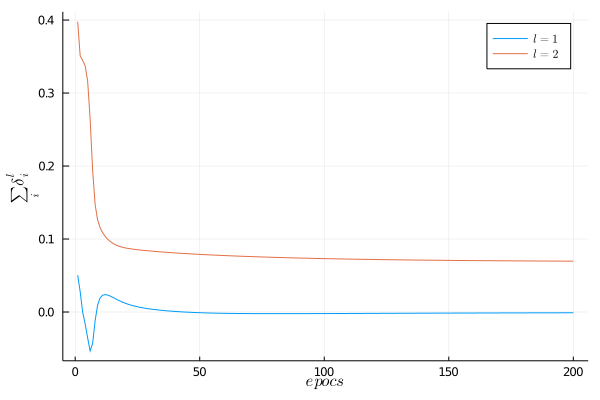

In [11]:
p = plot(grads, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$", label = [L"$l=1$" L"$l=2$"])
save = true
if save
    savefig("../article/figs/gradients-encoder.pdf")
end
p


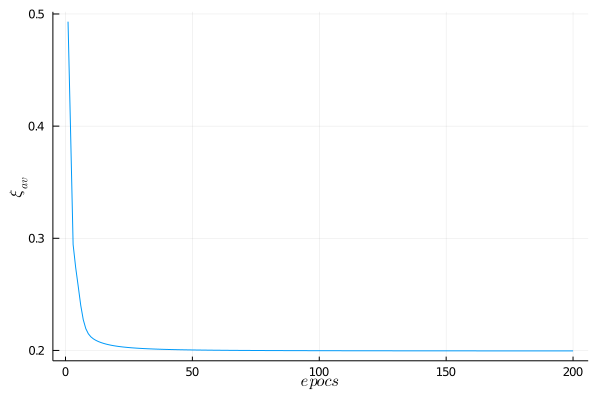

In [12]:
avg_err_plt = sum(avg_err / size(avg_err, 2), dims = 2)
p = plot(avg_err_plt, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)
save = true
if save
    savefig("../article/figs/avg-err-encoder.pdf")
end
p


## Learn Data


In [13]:
brain = Brain(size(datax, 2), size(datay, 2), [3], [sig, sig])
brain_red = Brain(size(datax_red, 2), size(datay, 2), [3], [sig, sig])

# Data separation
train_data, _, _ = create_data("../../supervised-learning/src/data/num-data.csv",
                               indexes_file="../../supervised-learning/src/data/indexes.csv")
train_datax = train_data[1]
train_datay = train_data[2]
train_datax_red = autoencoder.reduce_dimensions(train_datax)

# Training
grads_br, avg_err_br = brain.learn_data(train_datax, train_datay, η=0.9, epocs=50)
grads_br_red, avg_err_br_red = brain_red.learn_data(train_datax_red, train_datay, η=0.9, epocs=50);


### Brain Higher Dimension


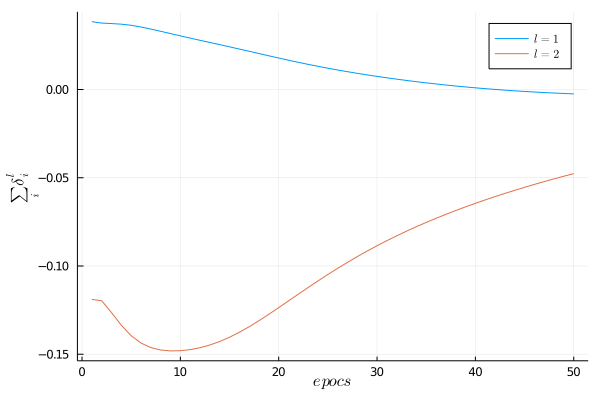

In [14]:
p = plot(grads_br, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$", label = [L"$l=1$" L"$l=2$"])
save = true
if save
    savefig("../article/figs/grads-learn-data.pdf")
end
p


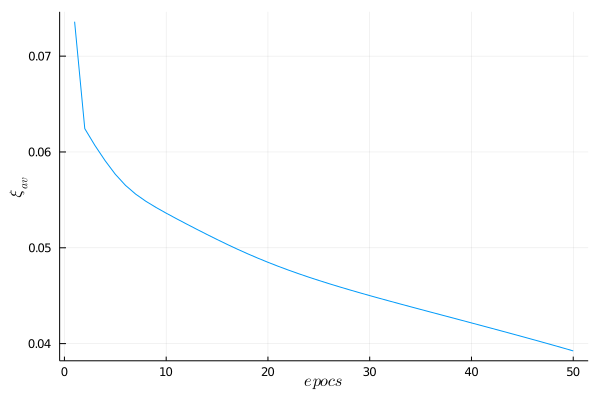

In [15]:
avg_err_plt_br = sum(avg_err_br / size(avg_err_br, 2), dims = 2)
p = plot(avg_err_plt_br, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)
save = true
if save
    savefig("../article/figs/avg-err-learn-data.pdf")
end
p


### Brain Reduced Dimension


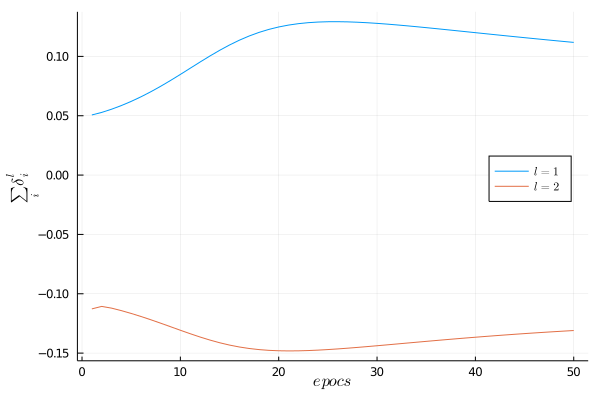

In [18]:
p = plot(grads_br_red, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$",
     label = [L"$l=1$" L"$l=2$"], legend = :right)
save = true
if save
    savefig("../article/figs/grads-learn-data-reduced.pdf")
end
p


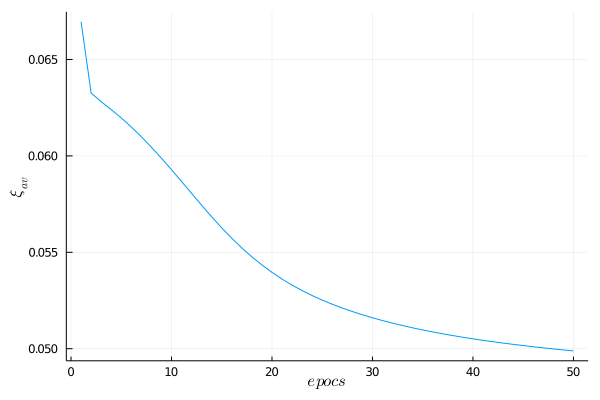

In [19]:
avg_err_plt_br_red = sum(avg_err_br_red / size(avg_err_br_red, 2), dims = 2)
p = plot(avg_err_plt_br_red, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)
save = true
if save
    savefig("../article/figs/avg-err-learn-data-reduced.pdf")
end
p


# LeNet 5
This code was based on an already implemented solution found in [this github
repository](https://bit.ly/3l82TMX). Most of the layers are re-written for a
better understanding and to follow the original article more closely. The code
for this section can be found in file `Lenet5.jl`.


# GAN MNIST
This code can be found in the fan `gan-mnist.ipynb`.
